# EEP/IAS 118 Research Project - Tiffany Lee (27035576)

## Research Question:

Has the legalization of marijuana through the passage of Proposition 64 reduced the crime rate?

## Motivation:

Four years ago, California passed Proposition 64 to legalize marijuana use. One of the major reasons why it got so much support from voters was because the supporters claimed that the legalization would help to reduce the crime rate. Now, four years later, it seems unclear what kind of effect the legalization has brought us. Hopefully, my research will show and bring more awareness to the after effects of the legalization.

## Research Design:

I intend to rely on a regression discontinuity design (RDD) because the RDD yields an unbiased estimate of the local treatment effect when properly implemented and analyzed. RDD gives us a way to set up a diff-in-diff-like comparison around a threshold and estimate a local treatment effect. It is almost comparable to a randomized experiment when measuring treatment effects. It allows us to compare outcomes around the threshold after the treatment has been applied with the assumption that values near the threshold will be reasonable counterfactuals for each other.

## Model:

$ \widehat{Crime\_rate}_i = \beta_0 + \beta_1\,period_i + \beta_2\,(Year_i - 2017) + \beta_3\,period_i \times (Year_i - 2017) + u_i $

where:
- $Crime\_rate$: the average crime rate calculated by the amount of violent and property crime in a county divided by the county population   
- $period$: A subset of the Year column with starting from 2017 and ending at 2019  
- $Year$: years between 2010 to 2019  
- $u$: error term  

Note: Since the legalization of Prop 64 (Adult Use of Marijuana Act) took effect in November 2016, it is logical and convenient for regression purposes to have the threshold = 2017.

### Sources of Data

The data for this research regression are downloaded from the following two government agencies:
- `Crimes_and_Clearances_with_Arson-1985-2019.csv` from [OpenJustice Portal from California Department of Justice](https://openjustice.doj.ca.gov/data)
- `co-est2019-annres-06.xlsx` (Annual Estimates of the Resident Population for Counties: April 1, 2010 to July 1, 2019) [Census Bureau](https://www.census.gov/data/datasets/time-series/demo/popest/2010s-counties-total.html)  

#### Ideal Dataset

An ideal dataset for my research question would be a time series containing crimes that will be affected by the legalization of marijuana. Since this is a direct legalization of marijuana, I should exclude any marijuana-related offenses. Seeing that there is no explicit mention of drug-related data in OpenJustice, we assume marijuana-related offenses in any form are not included in the data available. It would be ideal if this was included in the dataset so I can be sure to exclude it from my model. Also, if the crime can be recorded in a more frequent rate like in terms of months instead of years, it would help to increase the resolution and accuracy of the analysis. However, it's typical for the government agencies to record the number of crimes per year. Although it's not ideal, I think it's still workable. 

### Data Prep

We start off by loading the libraries needed to analyze the data.

In [15]:
suppressMessages(library(tidyverse))
suppressMessages(library(magrittr))
library(readxl)
library(broom)
library(plotrix)
suppressMessages(library(rddtools))
library(rdd)

Loading required package: Formula



We then read data into two data frames: `cpop` and `crimedf`.

In [3]:
cpop <- read_excel("data/co-est2019-annres-06_edit.xlsx")
head(cpop,3)

Geographical_Area,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
".Alameda County, California",1512986,1530915,1553764,1579593,1607792,1634538,1650950,1660196,1666756,1671329
".Alpine County, California",1161,1093,1110,1128,1080,1077,1047,1111,1089,1129
".Amador County, California",37886,37543,37104,36620,36726,37031,37429,38529,39405,39752


In [5]:
crimedf <- read.csv("data/Crimes_and_Clearances_with_Arson-1985-2019.csv")
head(crimedf,3)

,Year,County,NCICCode,Violent_sum,Homicide_sum,ForRape_sum,Robbery_sum,AggAssault_sum,Property_sum,Burglary_sum,⋯,MVLARnao_sum,MVPLARnao_sum,BILARnao_sum,FBLARnao_sum,COMLARnao_sum,AOLARnao_sum,LT400nao_sum,LT200400nao_sum,LT50200nao_sum,LT50nao_sum
,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1985,Alameda County,Alameda Co. Sheriff's Department,427,3,27,166,231,3964,1483,⋯,930,109,205,44,11,475,753,437,440,498
2,1985,Alameda County,Alameda,405,7,15,220,163,4486,989,⋯,538,673,516,183,53,559,540,622,916,1159
3,1985,Alameda County,Albany,101,1,4,58,38,634,161,⋯,147,62,39,46,17,37,84,68,128,138


#### Data Cleanup and Conditioning

In [4]:
cpop2 <- cpop %>%
  rename(County = Geographical_Area)  %>%
  mutate(County = str_replace(County,"^\\.",""),
         County = str_replace(County,", California.*",""),
         County = factor(County)) %>%
  gather(Year, Pop,-County, factor_key=TRUE) %>%
  mutate(Year = as.integer(levels(Year))[Year])
head(cpop2,3)

County,Year,Pop
<fct>,<int>,<dbl>
Alameda County,2010,1512986
Alpine County,2010,1161
Amador County,2010,37886


In [24]:
crimedf2 <- crimedf %>%
   filter((Year >= 2010) & (Year <= 2019)) %>%
   mutate(Year,Tot_crime = Violent_sum + Property_sum) %>%
   group_by(Year,County) %>%
   summarize(Cnty_crime = sum(Tot_crime)) 
head(crimedf2,3)

`summarise()` regrouping output by 'Year' (override with `.groups` argument)



Year,County,Cnty_crime
<int>,<fct>,<int>
2010,Alameda County,60791
2010,Alpine County,87
2010,Amador County,950


The dataframe `crimedfpop` to be used for regression are created by merging the two dataframes `cpop2` and `crimedf` together after they have been cleaned up and prepped.

In [7]:
crimedfpop <- merge(crimedf2, cpop2, by.x=c("County", "Year"), by.y=c("County", "Year"))
head(crimedfpop,3)

,County,Year,Cnty_crime,Pop
,<fct>,<int>,<int>,<dbl>
1,Alameda County,2010,60791,1512986
2,Alameda County,2011,63444,1530915
3,Alameda County,2012,74029,1553764


The dataframe `crimedfpop2` filters out any cities with a population less than 2000 people (since this may cause outliers) and adds a column to include the crime rate.

In [27]:
crimedfpop2 <-crimedfpop %>%
  filter(Pop > 2000) %>%
  mutate(Crime_rate = Cnty_crime / Pop * 1000) 
head(crimedfpop2,3)

,County,Year,Cnty_crime,Pop,Crime_rate
,<fct>,<int>,<int>,<dbl>,<dbl>
1,Alameda County,2010,60791,1512986,40.17949
2,Alameda County,2011,63444,1530915,41.44188
3,Alameda County,2012,74029,1553764,47.64494


### Data Exploration and Analysis

As mentioned earlier, the threshold is set to 2017. We expect a discontinuity at 2017. Let's plot a scatterplot.

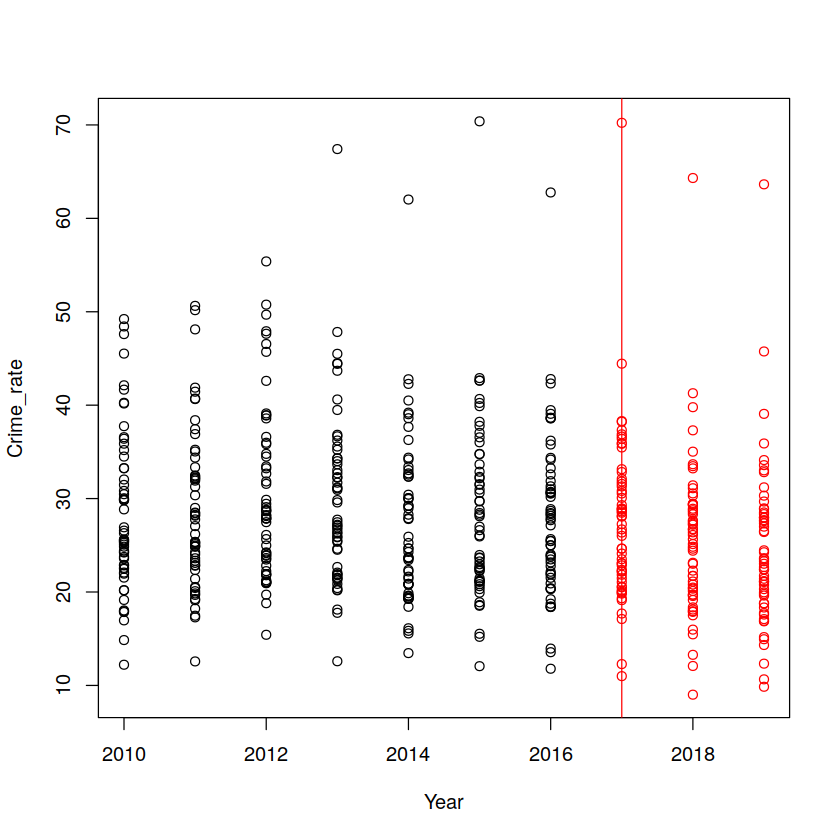

In [11]:
plot(Crime_rate ~ Year, data = crimedfpop2, col=(1+crimedfpop2$Year %/% 2017))
abline(v = 2017, col = "red")

Seems the scatterplot has a downward trend. Let's plot using `scatter.smooth()`.

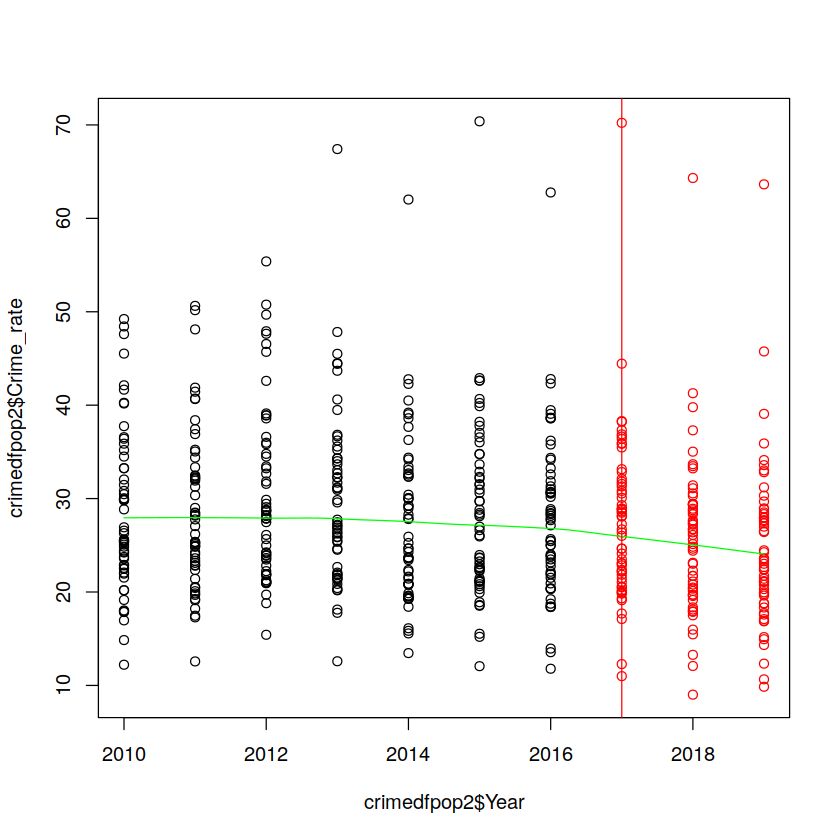

In [12]:
scatter.smooth(crimedfpop2$Year,crimedfpop2$Crime_rate, col=(1+crimedfpop2$Year %/% 2017), 
               lpars = list(col = "green"))
abline(v=2017,col="red")

As the `scatter.smooth()` plot shows, there is a transition in slope around 2017. We see that there is a slight decrease in crime rate after the legalization of recreational marijuana but it is not a dramatic drop. In general, the crime has been on a downward trend over the course of 10 years but it decreased at a faster rate after the legalization.

As we mentioned earlier, here is the regression model:

$ \widehat{Crime\_rate}_i = \beta_0 + \beta_1\,period_i + \beta_2\,(Year_i - 2017) + \beta_3\,period_i \times (Year_i - 2017) + u_i $

where:
- $Crime\_rate$: the crime rate calculated by the amount of violent and property crime in a county divided by the county population   
- $period$: A subset of the Year column with starting from 2017 and ending at 2019  
- $Year$: years between 2010 to 2019  
- $u$: error term  

To make sure we're using the right model, we're going to explore 2 possibilities:
1. Same slope
   - when the model formula has same slope before and after the threshold, it implies $\beta_3$ is zero. It becomes something like this:
     $ \widehat{Crime\_rate}_i = \beta_0 + \beta_1\,period_i + \beta_2\,(Year_i - 2017) + u_i $
2. Separate slope
      - when the model formula has separate slope before and after the threshold, it implies $\beta_3$ is nonzero. It becomes something like this:
     $ \widehat{Crime\_rate}_i = \beta_0 + \beta_1\,period_i + \beta_2\,(Year_i - 2017) + \beta_3\,period_i \times (Year_i - 2017) + u_i $


#### Same Slopes

In [145]:
reg_same <- crimedfpop2 %>% 
  mutate(period = ifelse(Year >= 2017, 1, 0)) %$% 
  lm(Crime_rate ~ period + I(Year - 2017))
summary(reg_same)


Call:
lm(formula = Crime_rate ~ period + I(Year - 2017))

Residuals:
    Min      1Q  Median      3Q     Max 
-17.356  -6.264  -1.186   4.504  43.936 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     27.6417     0.9667  28.594   <2e-16 ***
period          -1.3501     1.3453  -1.004    0.316    
I(Year - 2017)  -0.2755     0.2146  -1.283    0.200    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.876 on 567 degrees of freedom
Multiple R-squared:  0.02233,	Adjusted R-squared:  0.01888 
F-statistic: 6.475 on 2 and 567 DF,  p-value: 0.001658


#### Separate Slopes

$ \widehat{Crime\_rate}_i = \beta_0 + \beta_1\,period_i + \beta_2\,(Year_i - 2017) + \beta_3\,period_i \times (Year_i - 2017) + u_i $

In [132]:
reg_sep <- crimedfpop2 %>% 
  mutate(period = ifelse(Year >= 2017, 1, 0)) %$% 
  lm(Crime_rate ~ period * I(Year - 2017)) 
summary(reg_sep)


Call:
lm(formula = Crime_rate ~ period * I(Year - 2017))

Residuals:
    Min      1Q  Median      3Q     Max 
-17.088  -6.313  -1.067   4.363  42.686 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)            27.9989     0.9923  28.216   <2e-16 ***
period                 -0.4570     1.4607  -0.313    0.754    
I(Year - 2017)         -0.1862     0.2219  -0.839    0.402    
period:I(Year - 2017)  -1.3396     0.8594  -1.559    0.120    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.864 on 566 degrees of freedom
Multiple R-squared:  0.02651,	Adjusted R-squared:  0.02135 
F-statistic: 5.138 on 3 and 566 DF,  p-value: 0.001638


With the regression summaries above, we have the regression formulas:


When $Year < 2017$, $period = 0$,  
$
\begin{alignat}{2}
&& Crime\_rate &= 27.6417 - 0.2755 \, (Year - 2017) \\
&&         &= 583.3252 - 0.2755 \, Year
\end{alignat}
$

When $Year \geq 2017$, $period = 1$,  
$
\begin{alignat}{2}
&& Crime\_rate &= 27.6417 - 1.3501 - 0.2755\,(Year - 2017) \\
&&            &= 581.9751 - 0.2755\,Year
\end{alignat}
$

The following is the plot of the "same slopes" RDD model:

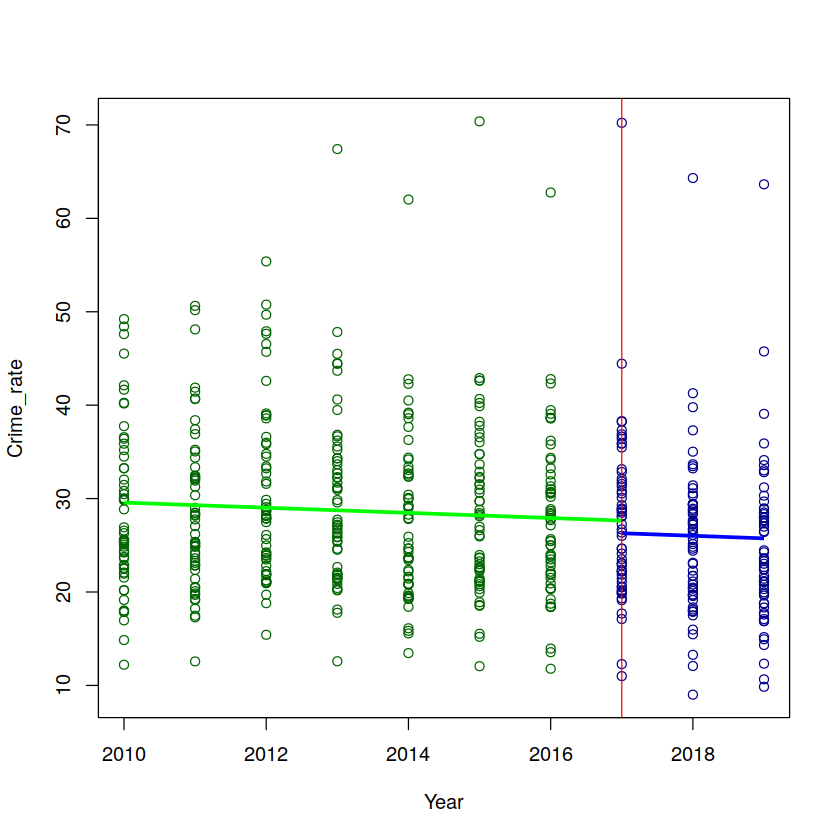

In [29]:
plot(Crime_rate ~ Year, data = crimedfpop2, col=ifelse(Year >= 2017, "darkblue","darkgreen"))
ablineclip(583.3252,-0.2755, x1=2010, x2=2017, col = "green", lwd = 3)
ablineclip(581.9751, -0.2755,x1=2017, x2=2019, col = "blue", lwd = 3)
abline(v=2017, col="red")

The following is the plot of the "separate slopes" RDD model:

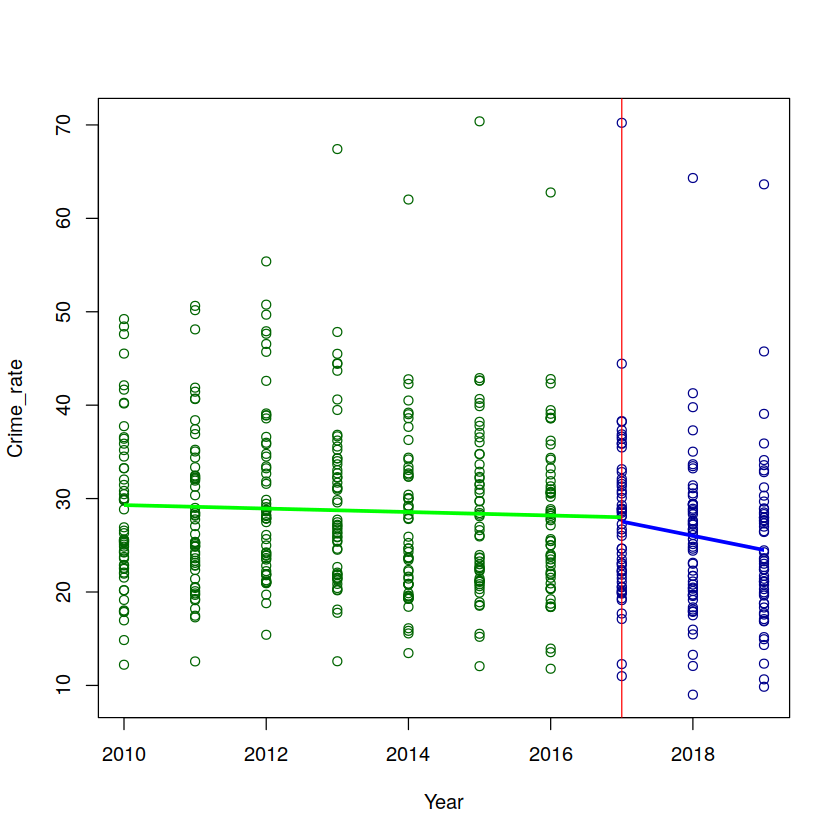

In [30]:
plot(Crime_rate ~ Year, data = crimedfpop2, col=ifelse(Year >= 2017, "darkblue","darkgreen"))
ablineclip(403.5643,-0.1862, x1=2010, x2=2017, col = "green", lwd = 3)
ablineclip(3105.0805, -1.5258,x1=2017, x2=2019, col = "blue", lwd = 3)
abline(v=2017, col="red")

By comparing the summaries of both "same slopes" and "separate slopes", we find that the Adjusted R-squared and the p-value for the "separate slopes" are slightly better than those of "same slopes":

**From the summary of "same slopes":**  
Residual standard error: 8.876 on 567 degrees of freedom  
Multiple R-squared:  0.02233,	**Adjusted R-squared:  0.01888**   
F-statistic: 6.475 on 2 and 567 DF,  **p-value: 0.001658**  

**From the summary of "separate slopes":**  
Residual standard error: 8.864 on 566 degrees of freedom  
Multiple R-squared:  0.02651,	**Adjusted R-squared:  0.02135**   
F-statistic: 5.138 on 3 and 566 DF,  **p-value: 0.001638**  

In this respect, I think we will pick "separate slopes" as the model for this research project.

To get a better view of the discontinuity, see below for the magnified version of the "separate slopes" plot above:

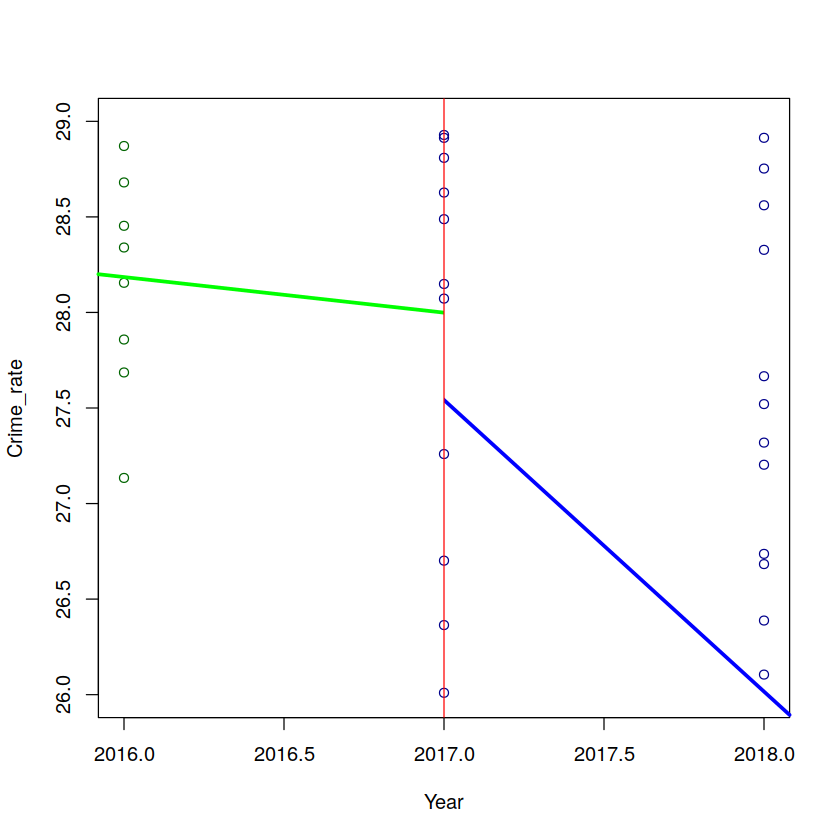

In [140]:
plot(Crime_rate ~ Year, data = crimedfpop2, col=ifelse(Year >= 2017, "darkblue","darkgreen"),
    xlim=c(2016,2018), ylim=c(26,29))
ablineclip(403.5643,-0.1862, x1=2010, x2=2017, col = "green", lwd = 3)
ablineclip(3105.0805, -1.5258,x1=2017, x2=2019, col = "blue", lwd = 3)
abline(v=2017, col="red")

### Interpretation

Since I picked "separate slopes" as the model for this research project, that is what I will use to interpret.

The intercept of the model $\beta_0$ is 27.9989.   
Sign: The intercept is positive. That means the base crime rate right before 2017 is positive.  
Significance: The p-value < 2e-16 and the corresponding t-statistic is 28.216 which means it is
statistically significant.  
Size: In a typical county in California, the base average crime rate is 27.9989 crimes per 1000 people in before 2017.

The coefficient of the $period$, $\beta_1$, is -0.4570.   
Sign: The coefficient of $period$ is negative. That means there is a difference in intercept for the treatment group for the crime rate of the running variable, `Year`, at the threshold.  
Significance: The p-value = 0.754 and the corresponding t-statistic is -0.313 which means it is
statistically insignificant but it may still be used as a reference.   
Size: In a typical county in California, the legalization of marijuana helped to reduce the average crime rate by 0.4570.

The coefficient of the $(Year - 2017)$, $\beta_2$, is -0.1862.   
Sign: The coefficient of $(Year - 2017)$ is negative. It reflects the downward trend of the crime rate changing over the years before the threshold.   
Significance: The p-value = 0.402 and the corresponding t-statistic is -0.839 which means it is
statistically insignificant but it may still be used as a reference.     
Size: In a typical county in California, before the legalization of marijuana, the crime rate is trending downward at a rate of 0.1862.  

The coefficient of the $period_i \times (Year_i - 2017)$, $\beta_3$, is -1.3396.   
Sign: The coefficient of $period_i \times (Year_i - 2017)$ is negative. It gives us the difference in trending slope over the years after the threshold. It reflects the steeper downward trend of the crime rate. 
Significance: The p-value = 0.120 and the corresponding t-statistic is -1.559 which means it is
statistically insignificant but it may still be used as a reference.   
Size: In a typical county in California, after the legalization of marijuana, the crime rate is further trending downward at an additional rate of 1.3396.  

## Assumptions:

In the model, the treatment is the legalization of marijuana due to the passage of Proposition 64. To allow us to identify the effect of the treatment, the crime rate before the threshold (`Year` = 2017) must constitute a good counterfactual to the crime rate after the treatment.

To see if our assumptions for the model to be identified will likely hold, we will account for other observable characteristics tied to the crime rate (e.g. the number of crimes observed, population changes, the minimum number of residents to calculate the crime rate, administrative divisions of Census data, sampling rate of data) on both sides of the threshold to test for discontinuities. The crime rate would be continuous around the threshold if there is no treatment. The legalization is the only explanation for any abrupt changes or discontinuities in crime rate. It is also assumed that there has been no manipulation or tampering of the crime data collected by the state's Department of Justice.

The following are taken into consideration through the regression:
1. the crime data are retrieved from [CA DOJ](https://openjustice.doj.ca.gov/data). 
  1. the number of crimes observed are aggregated to county level from the per city and per sheriff records.
  1. Marijuana-related offenses are excluded.
  1. Mainly violent crimes included.
1. the populations (number of residents) are acquired from [Census Bureau](https://www.census.gov/data/datasets/time-series/demo/popest/2010s-counties-total.html). Population size are based on the record from the Census.

The time-series on crime rate is computed with the formula as follows:

$ Tot\_crime_{i,Year} = Violent\_sum_{i,Year} + Property\_sum_{i,Year} $ 

$Crime\_rate_{County, Year} = \dfrac{\sideset{}{_{i=1}^{N}}\sum Tot\_crime_{i, Year}}{Total\:Population\:of\:County_{County,Year}}$

where 
* $N$ = num of cities/Sheriff in the county
* $Tot\_crime$ = Total crime per city or sherif
* $Crime\_rate$ = Crime\_rate per county

## Threats to identification (Bias):

Since the crime rate in the model is based on violent crimes, it can be affected by other treatments. If another treatment was applied around the same period of time and share the similar threshold, then it would obfuscate the measured discontinuity in the outcome variable due the influence of the other treatment(s). If this happens, this can be considered as a contamination of the treatment we are researching on (i.e. legalization of marijuana). Some treatments that can contribute to bias in our estimates include:
- a police campaign to crackdown on crimes in the same period
- an economic downturn affecting people's livelihoods which could lead to them considering crime as a choice to get what they desire
- changes in the composition of the population such as immigration or job market boom/decline 
- policy changes like early release of inmates